# **Model and Evaluation Notebook using Artificial Neuron Networks**

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission'

## Load data

We load our dataset and drop the 'medical_specialty' variable, as we determined in the Data Cleaning Notebook.

In [6]:
import pandas as pd
import numpy as np

data_path = 'outputs/datasets/collection/HospitalReadmissions.csv'

df = pd.read_csv(data_path).drop(labels=['medical_specialty'], axis=1)
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Circulatory,Respiratory,Other,no,no,no,yes,0
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,no,no,no,yes,0
2,[50-60),5,45,0,18,0,0,0,Circulatory,Circulatory,Circulatory,no,no,yes,yes,1
3,[70-80),2,36,0,12,1,0,0,Circulatory,Other,Diabetes,no,no,yes,yes,1
4,[60-70),1,42,0,7,0,0,0,Other,Circulatory,Respiratory,no,no,no,yes,0


---

## Variables separation

In [7]:
categorical_variables = df.select_dtypes(include='object').columns
categorical_variables_list = categorical_variables.tolist()
categorical_variables_list

['age',
 'diag_1',
 'diag_2',
 'diag_3',
 'glucose_test',
 'A1Ctest',
 'change',
 'diabetes_med']

In [8]:
numerical_variables = df.select_dtypes(include='number').columns.drop(labels=['readmitted'])
numerical_variables_list = numerical_variables.tolist()
numerical_variables_list

['time_in_hospital',
 'n_lab_procedures',
 'n_procedures',
 'n_medications',
 'n_outpatient',
 'n_inpatient',
 'n_emergency']

In [9]:
num_vars_iqr = df.filter(['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_inpatient']).select_dtypes(include='number').columns
num_vars_iqr_list = num_vars_iqr.to_list()
num_vars_iqr_list

['time_in_hospital',
 'n_lab_procedures',
 'n_procedures',
 'n_medications',
 'n_inpatient']

In [10]:
num_vars_gausian = df.filter(['n_emergency','n_outpatient']).select_dtypes(include='number').columns
num_vars_gausian_list = num_vars_gausian.to_list()
num_vars_gausian_list

['n_emergency', 'n_outpatient']

## Split to Train, Test and Validation sets

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['readmitted'], axis=1),
    df['readmitted'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (20000, 15) (20000,) 
* Test set: (5000, 15) (5000,)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape)
print("* Validation set:",  X_val.shape, y_val.shape)
print("* Test set:",   X_test.shape, y_test.shape)

* Train set: (16000, 15) (16000,)
* Validation set: (4000, 15) (4000,)
* Test set: (5000, 15) (5000,)


## Create Feature Engineering Pipeline

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OrdinalEncoder
from feature_engine.outliers import Winsorizer

def pipeline_for_feat_eng():
    pipeline_base = Pipeline([
        ('winsorizer_iqr', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=num_vars_iqr_list)),
        ('winsorizer_gaussian', Winsorizer(capping_method='gaussian', tail='both', fold=3, variables=num_vars_gausian_list)),
        ('ordinalEncoder', OrdinalEncoder(variables=categorical_variables_list, encoding_method='arbitrary')),
        ('scaler', StandardScaler())
    ])
    
    return pipeline_base

In [14]:
pipeline = pipeline_for_feat_eng()
X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

X_train[:2,]

array([[-1.37244075, -0.83537596,  0.14795637, -0.82212825, -0.41407702,
        -0.37833337, -0.63518958, -0.31508051, -1.33226096, -0.9712999 ,
        -1.19502738, -0.22827901, -2.66885676, -1.09844991, -0.55193427],
       [-0.72393504, -1.17846379, -0.45825396, -0.18832021, -1.66559014,
        -0.37833337, -0.63518958, -0.31508051, -0.80316606, -0.3855399 ,
        -1.19502738, -0.22827901, -0.16068007, -1.09844991, -0.55193427]])

## Build, fit_transform and evaluate the artificial neuron network

In [15]:
import tensorflow as tf;
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2';
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

def create_tf_model_sigmoid(n_features):

    model = Sequential()
    model.add(Dense(units=n_features,activation='relu', input_shape=(n_features,)))
    model.add(Dropout(0.3))
    
    model.add(Dense(units=256,activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(units=128,activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=64,activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=32,activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(units=16,activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(units=8,activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(units=4,activation='relu'))
    model.add(Dropout(0.3))

    # note we use 1 neuron and sigmoid
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [16]:
model = create_tf_model_sigmoid(n_features=X_train.shape[1])
model.summary()

c:\Users\Andrias\Desktop\project_venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,273 (188.57 KB)

 Trainable params: 48,273 (188.57 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.001)

In [19]:
model = create_tf_model_sigmoid(n_features=X_train.shape[1])
model.fit(x=X_train, 
        y=y_train,
        batch_size=16,
        epochs=100,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[early_stop, reduce_lr]
        )

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5331 - loss: 0.6919 - val_accuracy: 0.5732 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5574 - loss: 0.6843 - val_accuracy: 0.5935 - val_loss: 0.6748 - learning_rate: 0.0010
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5745 - loss: 0.6798 - val_accuracy: 0.5995 - val_loss: 0.6733 - learning_rate: 0.0010
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5767 - loss: 0.6787 - val_accuracy: 0.6195 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5936 - loss: 0.6723 - val_accuracy: 0.6180 - val_loss: 0.6666 - learning_rate: 0.0010
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5871 - loss: 0.6732 - val_accuracy: 0.6180 - val_loss: 0.6689 - learning_rate: 0.0010
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0

In [20]:
history = pd.DataFrame(model.history.history)
history

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.548688,0.688643,0.57325,0.681543,0.001
1,0.566437,0.681737,0.59350,0.674804,0.001
2,0.576563,0.678530,0.59950,0.673331,0.001
3,0.580187,0.676755,0.61950,0.661653,0.001
4,0.589437,0.673263,0.61800,0.666577,0.001
5,0.589250,0.672400,0.61800,0.668856,0.001
6,0.585250,0.672889,0.60700,0.671865,0.001
7,0.591875,0.670172,0.60900,0.664164,0.001
8,0.597000,0.670918,0.61475,0.664104,0.001
9,0.590875,0.671945,0.60900,0.670095,0.001


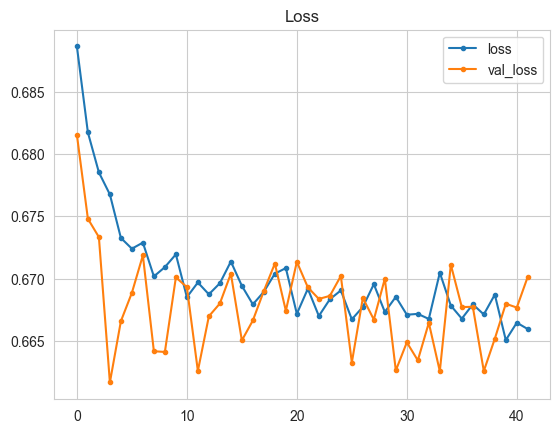

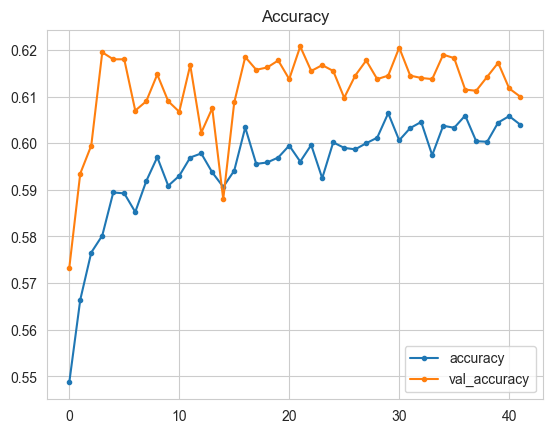

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
history[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.show()

print("\n")
history[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.show()

## Fit and evaluate the Test set

In [22]:
model.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6080 - loss: 0.6754


[0.6753600835800171, 0.6057999730110168]

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X,y,pipeline,label_map):
    prediction = pipeline.predict(X).reshape(-1)
    prediction = np.where(prediction<0.5,0,1) 
    # the prediction using sigmoid as an activation function is a probability number, between 0 and 1
    # we convert it to 0 or 1, if it is lower than 0.5, the predicted class is 0, otherwise it is 1
    # you could change the threshold if you want.

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
            columns=[ ["Actual " + sub for sub in label_map] ], 
            index= [ ["Prediction " + sub for sub in label_map ]]
            ))
    print("\n")


    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map),"\n")



def clf_performance(X_train,y_train,X_test,y_test,X_val, y_val,pipeline,label_map):

    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train,y_train,pipeline,label_map)

    print("#### Validation Set #### \n")
    confusion_matrix_and_report(X_val,y_val,pipeline,label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test,y_test,pipeline,label_map)

In [24]:

clf_performance(X_train, y_train,
                X_test,y_test,
                X_val, y_val,
                model,
                label_map= ['not readmitted', 'readmitted']
                )

#### Train Set #### 

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
---  Confusion Matrix  ---
                          Actual not readmitted Actual readmitted
Prediction not readmitted                  6233              3748
Prediction readmitted                      2344              3675


---  Classification Report  ---
                precision    recall  f1-score   support

not readmitted       0.62      0.73      0.67      8577
    readmitted       0.61      0.50      0.55      7423

      accuracy                           0.62     16000
     macro avg       0.62      0.61      0.61     16000
  weighted avg       0.62      0.62      0.61     16000
 

#### Validation Set #### 

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
---  Confusion Matrix  ---
                          Actual not readmitted Actual readmitted
Prediction not readmitted                  1499               956
Prediction readmitted                       604               941


---  Classification Report  ---
          

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [25]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)


IndentationError: expected an indented block after 'try' statement on line 2 (2852421808.py, line 5)